In [2]:
using SeisNoise, SeisIO, Plots
using Dates 
using Plots
using SeisDvv
using CSV
using Statistics
using LinearAlgebra
using Deconvolution

In [8]:
# Define the ncf_denoise function
function ncf_denoise(img_to_denoise::Matrix{Float32}, mdate::Int64, ntau::Int64, nsv::Int64, nsv_to_rm::Int64, use_wiener::Bool, noise_power::Float64)
    m, n = size(img_to_denoise)
    nsv = min(nsv, m, n)

    U, s, V = svd(img_to_denoise)
    Xwiener = zeros(Float32, size(img_to_denoise))  # Ensure the type is Float32

    for kk in (nsv_to_rm + 1):nsv
        SV = Diagonal([kk == i ? s[kk] : 0 for i in 1:min(m, n)])

        X = U * SV * V'

        if use_wiener
            # Convert X to Float64 if necessary
            X64 = convert(Matrix{Float64}, X)
            Xwiener += wiener(X64, X64, noise_power)
        else
            Xwiener += X
        end
    end

    if use_wiener
        # Final Wiener filter application, converting Xwiener to Float64
        Xwiener64 = convert(Matrix{Float64}, Xwiener)
        return wiener(Xwiener64, Xwiener64, noise_power)
    else
        return Xwiener
    end
end

# Convert UNIX timestamp to DateTime
unixtimestamp_to_datetime(ts) = unix2datetime(ts)

function find_indices_in_window(start_times, window_start, window_end)
    return findall(t -> window_start <= unixtimestamp_to_datetime(t) <= window_end, start_times)
end

function stack_moving_window(corr_data, window_size_days, overlap_days)
    window_size = Day(window_size_days)
    overlap = Day(overlap_days)

    # Initialize a matrix for the stacked correlations and a vector for the start times
    stacked_correlations_matrix = Array{Float32}(undef, 8001, 0)
    stacked_start_times = Float64[]

    current_start_date = unixtimestamp_to_datetime(first(corr_data.t))

    while current_start_date <= unixtimestamp_to_datetime(last(corr_data.t))
        current_end_date = current_start_date + window_size - Day(1)
        indices = find_indices_in_window(corr_data.t, current_start_date, current_end_date)

        if length(indices) > 0
            window_data = deepcopy(corr_data)
            window_data.corr = corr_data.corr[:, indices]
            stacked_corr = stack(window_data, allstack=true).corr

            # Append the stacked correlation as a new column
            stacked_correlations_matrix = hcat(stacked_correlations_matrix, stacked_corr)

            # Append the start time of the window
            push!(stacked_start_times, datetime2unix(current_start_date))
        end

        current_start_date += overlap
    end

    # Create a new CorrData instance with the stacked data
    new_corr_data = deepcopy(corr_data)
    new_corr_data.corr = stacked_correlations_matrix
    new_corr_data.t = stacked_start_times

    return new_corr_data
end


# Averaging function for causal and acausal parts
function average_causal_acausal(corr, time)
    averaged_corr = copy(corr)
    causal_index = findfirst(time .>= 0)
    acausal_index = findlast(time .< 0)

    for k in 1:causal_index-1
        if acausal_index - k + 1 > 0
            averaged_corr[causal_index + k - 1] = (averaged_corr[acausal_index - k + 1] + averaged_corr[causal_index + k - 1]) / 2
        end
    end

    return averaged_corr
end

# Function to create an evenly spaced array
function evenly_spaced(a, b, n)
    h = (b - a) / (n - 1)
    collect(a:h:b)
end

function update_progress_bar(current_step::Int, start_step::Int, end_step::Int)
    total_steps = end_step - start_step
    progress = (current_step - start_step) / total_steps
    filled_length = round(Int, 50 * progress)
    bar = repeat('█', filled_length) * repeat(' ', 50 - filled_length)
    print("\rProgress: |$bar| $(round(progress * 100))% Complete")
end

update_progress_bar (generic function with 1 method)

In [4]:
function ncf_denoise(img_to_denoise::Matrix{Float32}, mdate::Int64, ntau::Int64, nsv::Int64, nsv_to_rm::Int64, use_wiener::Bool, noise_power::Float64)
    m, n = size(img_to_denoise)
    nsv = min(nsv, m, n)  # Ensure nsv does not exceed the dimensions of the image

    U, s, V = svd(img_to_denoise)  # Perform singular value decomposition
    Xwiener = zeros(Float32, m, n)  # Initialize the result matrix of type Float32
    
    total_steps = nsv - nsv_to_rm  # Calculate total steps required for the loop
    println("Starting denoising...")  # Initial message before processing starts

    for kk in (nsv_to_rm + 1):nsv
        # Perform rank-1 updates using only significant singular values
        Xwiener .+= U[:, kk] * s[kk] * V[:, kk]'  # Scale outer product by the singular value
        
        # Progress bar update
        progress = (kk - nsv_to_rm) / total_steps  # Calculate progress ratio
        filled_length = round(Int, 50 * progress)  # Calculate number of blocks to fill
        bar = repeat('█', filled_length) * repeat(' ', 50 - filled_length)  # Create progress bar
        print("\rProgress: |$bar| $(round(progress * 100))% Complete")  # Print progress bar
    end
    
    println("\nDenoising completed.")  # End message after processing completes

    return Xwiener  # Return the reconstructed, denoised image
end

ncf_denoise (generic function with 1 method)

In [5]:
dd = load_corr("/data/wsd02/maleen_data/C_test/OO.HYSB1..BHN.OO.HYSB1..BHE.jld2", "NE");

In [6]:
#facilitating HYS14/HYSB1
ndaystack = 1
inter = Day(ndaystack)
d=stack(dd,interval=inter)


CorrData with 2148 Corrs
      NAME: "OO.HYSB1..BHN.OO.HYSB1..BHE"      
        ID: "2014-11-04"                       
       LOC: 0.0 N, 0.0 E, 0.0 m
      COMP: "NE"                               
   ROTATED: false                              
 CORR_TYPE: "CC"                               
        FS: 40.0
      GAIN: 1.0
   FREQMIN: 0.01
   FREQMAX: 16.0
    CC_LEN: 1800.0
   CC_STEP: 450.0
  WHITENED: true                               
 TIME_NORM: ""                                 
      RESP: a0 1.0, f0 1.0, 1z, 1p
      MISC: 0 entries                          
     NOTES: 9 entries                          
      DIST: 0.0
       AZI: 0.0
       BAZ: 0.0
    MAXLAG: 100.0
         T: 2014-11-04T00:00:00                …
      CORR: 8001×2148 Matrix{Float32}          


In [7]:
### TO REMOVE CROSS CORRELATION FUNCTIONS THAT ARE BAD FROM THE STACK
using Dates

# Convert d.t to DateTime objects
dt_dates = [unix2datetime(ts) for ts in d.t]

# Define the date ranges to exclude
exclude_ranges = [(DateTime(2013,1,1), DateTime(2017,1,1))]

# Find indices of dates within the specified ranges
indices_to_remove = findall(dt -> any(start_date <= dt <= end_date for (start_date, end_date) in exclude_ranges), dt_dates)
d.t = deleteat!(d.t, indices_to_remove)
# Identify all column indices
total_columns = size(d.corr, 2)
all_indices = 1:total_columns

# Determine the indices of columns to keep
indices_to_keep = setdiff(all_indices, indices_to_remove)

# Update t.corr by keeping only the desired columns
d.corr = d.corr[:, indices_to_keep];

In [9]:
# Preprocess your data
mnf = 1.0
mxf = 3.0
ndaystack = 40
remove_nan!(d)

allstk = stack(d, allstack=true)
clean_up!(allstk, mnf, mxf)
abs_max!(allstk)
#inter = Day(1)
#dailystk = stack(d, interval=inter)

dailystk = stack_moving_window(d, ndaystack, 1)
clean_up!(dailystk, mnf, mxf)
abs_max!(dailystk)
dailystk1=deepcopy(dailystk)

CorrData with 1450 Corrs
      NAME: "OO.HYSB1..BHN.OO.HYSB1..BHE"      
        ID: "2014-11-04"                       
       LOC: 0.0 N, 0.0 E, 0.0 m
      COMP: "NE"                               
   ROTATED: false                              
 CORR_TYPE: "CC"                               
        FS: 40.0
      GAIN: 1.0
   FREQMIN: 1.0
   FREQMAX: 3.0
    CC_LEN: 1800.0
   CC_STEP: 450.0
  WHITENED: true                               
 TIME_NORM: ""                                 
      RESP: a0 1.0, f0 1.0, 1z, 1p
      MISC: 0 entries                          
     NOTES: 9 entries                          
      DIST: 0.0
       AZI: 0.0
       BAZ: 0.0
    MAXLAG: 100.0
         T: 2017-01-02T00:00:00                …
      CORR: 8001×1450 Matrix{Float32}          


In [10]:
#remove_nan!(d)
#dailystk = stack_moving_window(d, 60, 1)
#abs_max!(dailystk)
#allstk = stack(d, allstack=true)
#abs_max!(allstk)

In [11]:
plot(dailystk,size=(1000, 500),left_margin=20Plots.mm, right_margin=5Plots.mm, bottom_margin=10Plots.mm, dpi=200,xlim=[-60,60])


In [12]:
lags = evenly_spaced(-100, 100, size(dailystk.corr, 1))

# Find the index of the maximum absolute value in allstk.corr
max_index = argmax((allstk.corr))

# Find the corresponding lag value
max_lag = lags[max_index]

println("Index of maximum absolute value: ", max_index)
println("Corresponding lag value: ", max_lag)
max_lag=0

Index of maximum absolute value: CartesianIndex(4010, 1)
Corresponding lag value: 0.225


0

In [13]:
# Denoise allstk and dailystk and store in the corrdata
mdate = 10
ntau = 10
nsv =5
nsv_to_rm = 0
use_wiener = false

# Estimate of the noise power (adjust based on your data)
noise_power = 0.03  # Example value, adjust as needed

allstk.corr = ncf_denoise(allstk.corr, mdate, ntau, nsv, nsv_to_rm, use_wiener, noise_power);

In [ ]:
dailystk.corr = ncf_denoise(dailystk.corr, mdate, ntau, nsv, nsv_to_rm, use_wiener, noise_power);

In [ ]:
using Plots
fig=plot(dailystk,size=(1000, 500),left_margin=20Plots.mm, right_margin=5Plots.mm, bottom_margin=10Plots.mm, dpi=200,xlim=[-10,10],grid=:true)
#savefig(fig, "B1140p1_0p3.png")

In [ ]:
using SeisNoise
using Plots
using Dates

function plot_corr_heatmap(C::CorrData)
    # Define lags in seconds
    lags = -C.maxlag : (1 / C.fs) : C.maxlag
    
    # Convert each Unix timestamp to DateTime and shift by +20 days
    datetimes_shifted = unix2datetime.(C.t) .+ Day(20)
    
    # Format them to strings without time part
    times_str = Dates.format.(datetimes_shifted, "yyyy/m/d")
    
    # Numeric y-values for each row in `C.corr'`
    yvals = 1:length(times_str)
    
    # Choose fewer y-tick positions to avoid a crowded axis
    # For instance, one label every 100 rows:
    tick_skip   = 100
    ytick_vals  = 1:tick_skip:length(yvals)
    ytick_labels = times_str[ytick_vals]

    # Create the heatmap with numeric y-values
    p = heatmap(
        lags,
        yvals,
        C.corr',
        size           = (1000, 500),
        left_margin    = 20Plots.mm,
        right_margin   = 5Plots.mm,
        bottom_margin  = 10Plots.mm,
        dpi            = 200,
        seriescolor    = :balance,
        ytickfontsize  = 10,
        xtickfontsize  = 8,
        xlim           = [-10, 10],
        grid           = :true,
        legend         = :false,
        gridalpha      = 1.0,
        gridlinewidth  = 2,
        gridcolor      = :black,
        framestyle     = :grid,
        # Only place ticks at y=ytick_vals, labeling them with shifted dates
        yticks         = (ytick_vals, ytick_labels),
    )

    # Add vertical lines at x = -4, -3, -2, -1, 0, 1, 2, 3, 4
    vlines = [-8,-6,-4,-2, 0, 2, 4, 6, 8]
    for x_val in vlines
        vline!([x_val], color = :black, linewidth = 1)
    end

    # Add horizontal lines every 100 rows
    for i in 1:100:length(yvals)
        hline!([i], color = :black, linewidth = 1)
    end

    return p
end

# Example usage (assuming `dailystk` is your CorrData object):
ppp = plot_corr_heatmap(dailystk)
display(ppp)


## Parallelized Stretching 

In [22]:
using Distributed

# Add processes (if not already added)
if nprocs() == 1  # Only the main process is running
    addprocs(18)  # Adjust the number as needed
end

@everywhere begin
    using SharedArrays, HDF5, Plots,SeisNoise, SeisIO, Plots
    using Dates 
    using Plots
    using SeisDvv
    # Ensure all necessary modules are loaded in each worker

    fs = 40.0     # sample frequency
    win_len = 2.0  # sliding window length
    win_step = 5.0 # sliding window step
    tmin = 1.0
    tmax = 5.0
    dmn = -0.15 #05
    dmx = 0.15 #05
end

# Define your data or load it in a way that each worker can access it
# Assuming dailystk.corr is accessible to all workers, or needs to be distributed
j = size(dailystk.corr, 2)
dvt = SharedArray{Float64}(j)
cct = SharedArray{Float64}(j)
cctb = SharedArray{Float64}(j)

@distributed for i = 1:j
    S1 = Array(allstk.corr[:])
    S2 = Array(dailystk.corr[:,i])
    rel_tmin_index = Int(floor((tmin + 100+max_lag) * fs))
    rel_tmax_index = Int(floor((tmax + 100+max_lag) * fs))
    
    window = collect(rel_tmin_index:rel_tmax_index)
    fmin = mnf  # Ensure mnf is defined or loaded
    fmax = mxf  # Ensure mxf is defined or loaded

    function evenly_spaced(a, b, n)
        h = (b - a) / (n - 1)
        collect(a:h:b)
    end

    time = evenly_spaced(-100, 100, size(dailystk.corr, 1))
    time = time.-max_lag

    dvv_ts, cc_ts, cdp_Ts, eps_ts, err_ts, allC_ts = SeisDvv.stretching(S1, S2, time, window, fmin, fmax, dvmin=dmn, dvmax=dmx, ntrial=1000)
    dvt[i] = dvv_ts
    cct[i] = cc_ts
    cctb[i] = cdp_Ts
end

println("Computation completed.")


Computation completed.


In [23]:
dt = map(unix2datetime, dailystk.t);
# Assuming datetime_vector is your 71-element Vector{DateTime} 
# and float_vector is your 71-element Vector{Float64}
datetime_vector = dt;  # fill this with your data
float_vector = dvt;  # fill this with your data
cctfilter = cct;

# Combine the vectors into a named tuple which CSV.File will interpret as a table
data = (DateTime=datetime_vector, Float=float_vector,cct);

# Set the threshold value
threshold = 0.9

# Filter the datetime and float vectors based on the threshold
filtered_indices = cct .>= threshold;
datetime_vector = datetime_vector[filtered_indices];
float_vector = float_vector[filtered_indices];
cctfilter = cct[filtered_indices];

# Calculate the Interquartile Range (IQR)
Q1 = quantile(float_vector, 0.1)#20)
Q3 = quantile(float_vector, 0.9)#80)
IQR = Q3 - Q1

# Calculate the lower and upper bounds to filter the outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Filter the vectors to remove the outliers
dtf = DateTime[]
dvtf = Float64[]
cctf = Float64[]
for i in 1:length(float_vector)
    if float_vector[i] >= lower_bound && float_vector[i] <= upper_bound
        push!(dtf, datetime_vector[i])
        push!(dvtf, float_vector[i])
        push!(cctf, cctfilter[i])
    end
end
# Calculate the mean and standard deviation
mean_value = mean(cct)
std_deviation = std(dvtf)

# Print the results
println("Mean of the float vector: $mean_value")
println("Standard deviation of the float vector: $std_deviation")

# Sample datetime_vector and dvtf
datetime_vector = dtf

# Find the minimum and maximum dates in the datetime_vector
min_date = minimum(datetime_vector)
max_date = maximum(datetime_vector)

# Generate all dates in the date rangeI'
all_dates = collect(min_date:Day(ndaystack):max_date)

# Find the dates that are in all_dates but not in datetime_vector (considering only the date part)
missing_dates = setdiff(all_dates, datetime_vector)

# Assuming dt, dvt, cct, and dailystk are defined
#dt = map(unix2datetime, dailystk.t)
ticks = dtf[1:100:end]
tick = Dates.format.(ticks, "yyyy-mm-dd")

# First subplot
p1 = plot(scatter(dtf, dvtf), seriestype = :line, xticks = (ticks, tick), xrot = -30, ylabel="dv/v %", legend=false)#,ylim=(-0.5, 0.5))
plot!(dtf, dvtf, seriestype = :line, xticks = (ticks, tick), xrot = -30, legend=false)
# For each missing date, add a vertical line to the plot
#for date in missing_dates
#    vline!(p1, [DateTime(date)], linecolor=:red, linewidth=2, linealpha=0.5, label="Missing Date")
#end


# Second subplot
p2 = plot(dtf, cctf, seriestype = :line, ylim = [0.6, 1], label = "cc", xticks = (ticks, tick), xrot = -30, left_margin = 10Plots.mm, ylabel="cc", xlabel="Date", legend=false)
hline!([0.8], label="Threshold", width=2, color=:red) # Adding a horizontal line at y=0.8

# Third subplot
p3 = plot(dailystk,xlim=[-10,10], left_margin = 10Plots.mm)

# The layout now specifies a grid of 3 rows and 1 column and gives the third plot even more vertical space compared to the first two.
l = @layout([a{0.3h}; b{0.2h}; c{0.5h}])

# Combine the plots
final_plot = plot(p1, p2, p3, layout = l, size = (1100, 1000), left_margin = 20Plots.mm, right_margin = 5Plots.mm)

# Save the plot
#savefig(final_plot, "$(d.name)_t$(tmin)-$(tmax)_freq$(mnf)-$(mxf)_stk$(ndaystack)SVD5s.png")

Mean of the float vector: 0.9961307533642614
Standard deviation of the float vector: 0.10227578705273756


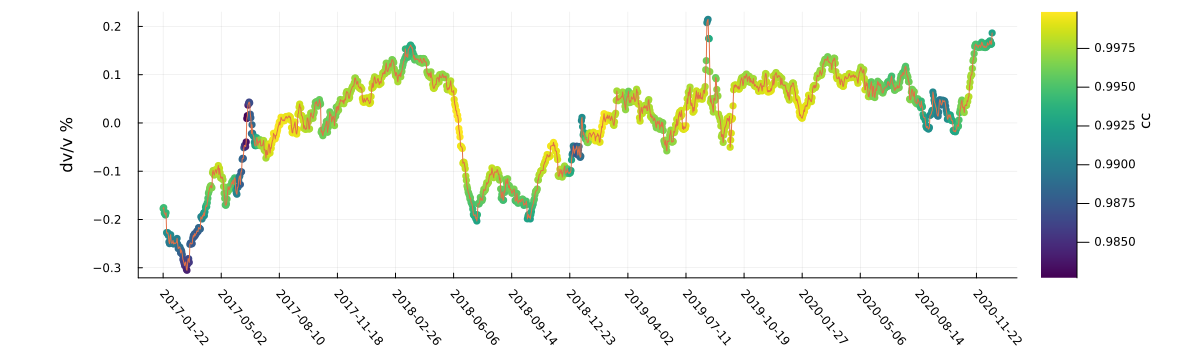

In [24]:
using Plots, Dates

# --- Define multiple ranges to exclude ---
ranges_to_exclude = [
    (Date("2020-11-30"), Date("2021-01-17"))
]

# 1. Build a mask for all excluded points
#    For each (start, end) pair, mark dtf .>= start AND dtf .<= end
excluded_mask = fill(false, length(dtf))  # start with all false
for (start_date, end_date) in ranges_to_exclude
    # Mark as true if within any of the exclusion ranges
    excluded_mask .|= (dtf .>= start_date) .& (dtf .<= end_date)
end

# 2. Take the negation to get the "keep" mask
mask = .!excluded_mask

# 3. Filter the data
filtered_dtf  = dtf[mask]
filtered_dvtf = dvtf[mask]
filtered_cctf = cctf[mask]

# --- Proceed with the plotting as usual ---
filtered_dtf_offset = filtered_dtf .+ Day(20)
# Update ticks based on filtered data
ticks = filtered_dtf_offset[1:100:end]
tick  = Dates.format.(ticks, "yyyy-mm-dd")

# Define a color gradient
my_colormap = :viridis

# Normalize cctf if needed (here we simply keep it as is)
normalized_cctf = filtered_cctf

# Add leading spaces to the color bar title to create more space
colorbar_title_with_space = "          cc"

# Create the plot
p1 = scatter(
    filtered_dtf_offset, filtered_dvtf,
    zcolor = normalized_cctf,
    color   = my_colormap,
    markerstrokewidth = 0,
    colorbar          = true,
    colorbar_title    = colorbar_title_with_space,
    seriestype        = :scatter,
    legend            = false,
    xticks            = (ticks, tick),
    xrot              = -30,
    ylabel            = "dv/v %",
    size              = (1000, 300),
    left_margin       = 20Plots.mm,
    right_margin      = 10Plots.mm,
    bottom_margin     = 10Plots.mm,
    dpi               = 200
)

# Optionally add another layer
plot!(
    p1,
    filtered_dtf_offset, filtered_dvtf,
    legend       = false,
    xticks       = (ticks, tick),
    xrot         = -50,
    size         = (1200, 350),
    #ylim         = (-0.12,0.12),
    left_margin  = 20Plots.mm,
    right_margin = 10Plots.mm,
    bottom_margin= 10Plots.mm,
    dpi          = 200
)

# Display the plot
display(p1)
# Save the figure if needed
savefig(p1, "HYSB1_35Hz_ne15sec_40d.png")
